# 6.3 Training Models

Module 6 - Video Action Recognition

For book, references and training materials, please check this project website [http://activefitness.ai/ai-in-sports-with-python](http://activefitness.ai/ai-in-sports-with-python).

Book: [Applied Machine Learning for Health and Fitness](https://www.apress.com/us/book/9781484257715), Chapter 9

In [12]:
import torch
import torchvision
import torchvision.models as models    

# check if cuda is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [17]:
import torch
import torchvision
import torchvision.models as models  

# Normalization: Kinetics 400
mean = [0.43216, 0.394666, 0.37645]  
std = [0.22803, 0.22145, 0.216989] 

def normalize(video): 
    return video.permute(3, 0, 1, 2).to(torch.float32) / 255

def resize(video, size): 
    return torch.nn.functional.interpolate(video, size=size, scale_factor=None, mode='bilinear', align_corners=False)

def crop(video, output_size): 
    # center crop    
    h, w = video.shape[-2:] 
    th, tw = output_size 
    i = int(round((h - th) / 2.)) 
    j = int(round((w - tw) / 2.)) 
    return video[..., i:(i + th), j:(j + tw)]

def normalize_base(video, mean, std): 
    shape = (-1,) + (1,) * (video.dim() - 1) 
    mean = torch.as_tensor(mean).reshape(shape) 
    std = torch.as_tensor(std).reshape(shape) 
    return (video - mean) / std

In [23]:
import torchvision.io 
video_file = 'media/surfing_backflip.mp4'
video, audio, info = torchvision.io.read_video(video_file, pts_unit='sec') 
print(video.shape, audio.shape, info)

torch.Size([195, 720, 1280, 3]) torch.Size([2, 311296]) {'video_fps': 29.97002997002997, 'audio_fps': 48000}


In [24]:
video = normalize(video) 
video = resize(video,(128, 171)) 
video = crop(video,(112, 112)) 
video = normalize_base(video, mean=mean, std=std)
shape = video.shape
print(f'frames {shape[0]}, size {shape[1]} {shape[2]}') 

frames 3, size 195 112


In [25]:
# score the video
score = model(video.unsqueeze(0)) 
# get prediction with max score
prediction = score.argmax() 
print(prediction)

tensor(337)


In [26]:
from utils.kinetics import kinetics
classes = kinetics.classes()
print(classes[prediction.item()])

surfing water


In [27]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torch.utils.data import DataLoader as DataLoader
from torchvision import transforms
from torchvision.datasets.kinetics import Kinetics400
from torchvision.datasets.samplers import DistributedSampler, UniformClipSampler, RandomClipSampler
import matplotlib.pyplot as plt
from pathlib import Path

Path.ls = lambda x: [o.name for o in x.iterdir()]
from torchvision.io.video import read_video
from functools import partial as partial
read_video = partial(read_video, pts_unit='sec')
torchvision.io.read_video = partial(torchvision.io.read_video, pts_unit = 'sec')

In [28]:
base_dir = Path('data/kinetics400/')
data_dir = base_dir/'dataset'

In [ ]:
!tree {data_dir/'train'}

In [30]:
data = torchvision.datasets.Kinetics400(
            data_dir/'train',
            frames_per_clip=32,
            step_between_clips=1,
            frame_rate=None,
            extensions=('mp4',),
            num_workers=0
        )

  0%|                                                                    | 0/41 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\envs\rl\lib\site-packages\torchvision\io\video.py:106: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results and will be removed in a " +
100%|███████████████████████████████████████████████████████████| 41/41 [18:08<00:00, 26.56s/it]


In [31]:
print((data[0][0]).shape)

torch.Size([32, 480, 272, 3])


### Visualizing dataset


In [32]:
import pandas as pd
from utils.video_classification.helpers import to_dataframe

to_dataframe(data)

Length: 153939


,filepath,frames,fps,clips
0,data\kinetics400\dataset\train\playing_tennis\...,300,30.000000,269
1,data\kinetics400\dataset\train\playing_tennis\...,140,14.000000,109
2,data\kinetics400\dataset\train\playing_tennis\...,100,10.000000,69
3,data\kinetics400\dataset\train\playing_tennis\...,100,10.000000,69
4,data\kinetics400\dataset\train\playing_tennis\...,89,15.000000,58
...,...,...,...,...
640,data\kinetics400\dataset\train\surfing_water\c...,300,29.970030,269
641,data\kinetics400\dataset\train\surfing_water\c...,240,23.974427,209
642,data\kinetics400\dataset\train\surfing_water\c...,300,29.970030,269
643,data\kinetics400\dataset\train\surfing_water\c...,250,25.000000,219


In [33]:
VIDEO_NUMBER = 130
video_table = to_dataframe(data)
video_info = video_table['filepath'][VIDEO_NUMBER]

Length: 153939


In [34]:
from IPython.display import Video
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Video(video_info, width=400, embed=False)

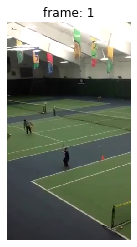

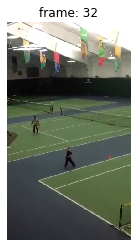

In [37]:
def show_clip_start_end(f):
    last = len(f)
    plt.imshow(f[0])
    plt.title(f'frame: 1')
    plt.axis('off')
    plt.show()
    plt.imshow(f[last-1])
    plt.title(f'frame: {last}')
    plt.axis('off')
    plt.show()

show_clip_start_end(data[0][0])

## Video normalization



In [43]:
import utils.video_classification.transforms as T

t = torchvision.transforms.Compose([
        T.ToFloatTensorInZeroOne(),
        T.Resize((128, 171)),
        T.RandomHorizontalFlip(),
        T.Normalize(mean=[0.43216, 0.394666, 0.37645],
                            std=[0.22803, 0.22145, 0.216989]),
        T.RandomCrop((112, 112))
    ])

In [44]:
train_data = torchvision.datasets.Kinetics400(
            data_dir/'train',
            frames_per_clip=32,
            step_between_clips=1,
            frame_rate=None,
            transform=t,
            extensions=('mp4',),
            num_workers=0
        )

100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.97s/it]


In [51]:
from torch_lr_finder import LRFinder

In [49]:
from utils.video_classification.first_clip_sampler import FirstClipSampler
from torch.utils.data.dataloader import default_collate

def collate_fn(batch):
    # remove audio from the batch
    batch = [(d[0], d[2]) for d in batch]
    return default_collate(batch)

train_sampler = FirstClipSampler(train_data.video_clips, 2)
train_dl = DataLoader(train_data, batch_size=4, sampler=train_sampler, collate_fn=collate_fn, pin_memory=True)
x,y = next(iter(train_dl))
x.shape, y.shape

(torch.Size([4, 3, 32, 112, 112]), torch.Size([4]))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-2)
# if you are getting memory problems running this, 
# try reducing DataLoader batch_size above to 16 or even 4
lr_finder = LRFinder(model, optimizer, criterion,device=device)
lr_finder.range_test(train_dl, end_lr=10, num_iter=90)
lr_finder.plot()
lr_finder.reset()

In [ ]:
train_data = torchvision.datasets.Kinetics400(
            data_dir/'train',
            frames_per_clip=32,
            step_between_clips=1,
            frame_rate=None,
            transform=t,
            extensions=('mp4',),
            num_workers=0
        )

valid_data = torchvision.datasets.Kinetics400(
            data_dir/'valid',
            frames_per_clip=32,
            step_between_clips=1,
            frame_rate=None,
            transform=t,
            extensions=('mp4',),
            num_workers=0
        )

In [ ]:
train_sampler = FirstClipSampler(train_data.video_clips, 2)
train_dl = DataLoader(train_data, 
                      batch_size=4, 
                      sampler=train_sampler, 
                      collate_fn=collate_fn, 
                      pin_memory=True)
valid_sampler = FirstClipSampler(valid_data.video_clips, 2)
valid_dl = DataLoader(valid_data, 
                      batch_size=4, 
                      sampler=valid_sampler, 
                      collate_fn=collate_fn, pin_memory=True)

In [ ]:
import os
cache_dir = data_dir/'.cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
cache_dir.ls()

torch.save(train_data, f'{cache_dir}/train')
torch.save(valid_data, f'{cache_dir}/valid')
train_data = torch.load(cache_dir/'train')
valid_data = torch.load(cache_dir/'valid') 

In [ ]:
import torch
import torchvision
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = models.video.r2plus1d_18()
model.cuda()
lr = 1e-2
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=5e-1, steps_per_epoch=len(train_dl), epochs=10)
metrics_dir = cache_dir/'train-metrics'

In [ ]:
import sys
import time
import datetime
from utils.video_classification.train import train_one_epoch, evaluate

start_time = time.time()
 
for epoch in range(10):
    train_one_epoch(model, 
                    criterion, 
                    optim, 
                    lr_scheduler, 
                    train_dl, device, 
                    epoch, print_freq=100)
    evaluate(model, 
             criterion, 
             valid_dl, 
             device)

total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))

In [ ]:
SAVED_MODEL_PATH = './videoresnet_action.pth'
torch.save(model.state_dict(), SAVED_MODEL_PATH)